In [12]:
!pip install -U \
  numpy \
  torch torchvision \
  pillow \
  opencv-python \
  PyWavelets \
  scipy \
  timm \
  tqdm

!pip install onnx onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 1.4 MB/s  0:00:13m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 894.8 kB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [onnxscript]3 [onnxscript]


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
import cv2
import pywt
from scipy.ndimage import median_filter
import timm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [2]:
class LeukemiaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for fold in ['fold_0', 'fold_1', 'fold_2']:
            for label, category in enumerate(['all', 'hem']):
                folder_path = os.path.join(root_dir, fold, category)
                for img_name in os.listdir(folder_path):
                    self.image_paths.append(os.path.join(folder_path, img_name))
                    self.labels.append(label)  # 0 for 'all', 1 for 'hem'

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image as it is (no preprocessing)
        image = Image.open(image_path).convert('RGB')

        # Apply augmentations
        if self.transform:
            image = self.transform(image)

        return image, label

# Define augmentation transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomRotation(30),  # Random rotation
    transforms.RandomHorizontalFlip(),  # Horizontal flipping
    transforms.ColorJitter(contrast=0.5),  # Contrast adjustment
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load dataset with augmentation only
dataset = LeukemiaDataset(root_dir="leukemia_nuclei/training_data", transform=transform)
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)

# Check batch shape
images, labels = next(iter(dataloader))
print(images.shape, labels.shape)  # Expected: (40, 3, 224, 224), (40,)

torch.Size([40, 3, 224, 224]) torch.Size([40])


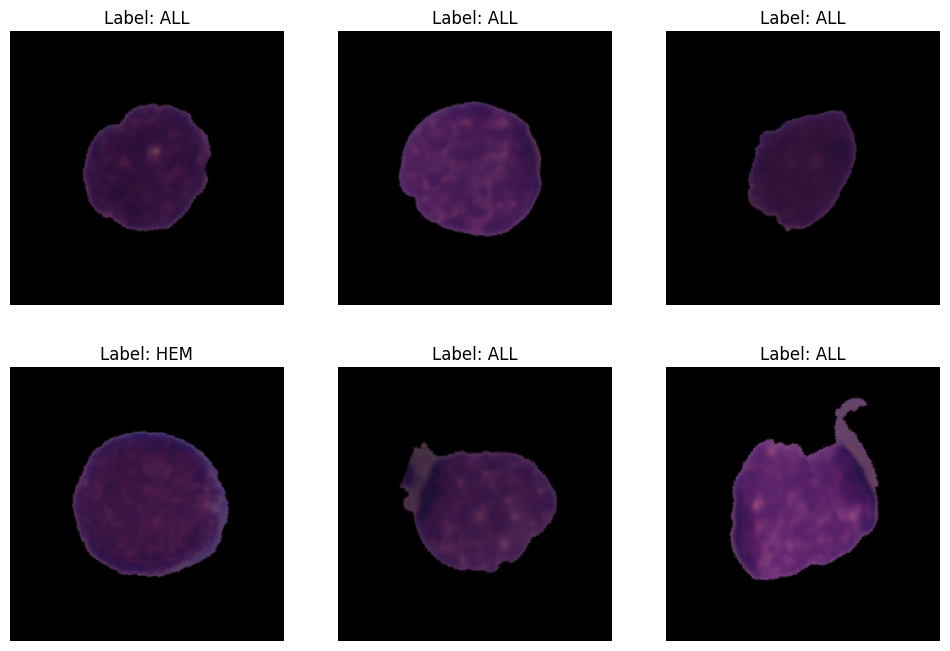

In [3]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(iter(dataloader))

# Convert images to numpy for visualization
def imshow(img, title):
    img = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5  # Denormalize (mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Display 6 images
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow(images[i], f"Label: {'ALL' if labels[i] == 0 else 'HEM'}")

plt.show()

In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

Using device: mps


In [5]:
import torch
import torch.nn as nn
import timm

class LeukemiaClassifier(nn.Module):
    def __init__(self):
        super(LeukemiaClassifier, self).__init__()
        # Load MobileNetV2 as base model
        self.base_model = timm.create_model('mobilenetv2_100', pretrained=True)

        # Get number of input features to classifier
        in_features = self.base_model.classifier.in_features  

        # Replace classifier head
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2),   # 2 classes: all, hem
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.base_model(x)

# Initialize model
# model = LeukemiaClassifier().cuda()
model = LeukemiaClassifier().to(device)


In [6]:
# Loss function (CrossEntropy for binary classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adamax)
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)

# Learning rate scheduler (reduce LR by 0.5 after 2 stagnant epochs)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [7]:
import time

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=40, patience=5):
    best_acc = 0.0
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train Phase
        model.train()
        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(dataloaders['train']):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.argmax(outputs, dim=1) == labels)

        train_loss /= len(dataloaders['train'].dataset)
        #train_acc = train_corrects.double() / len(dataloaders['train'].dataset)
        train_acc = train_corrects.float() / len(dataloaders['train'].dataset)

        # Validation Phase
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(torch.argmax(outputs, dim=1) == labels)

        val_loss /= len(dataloaders['val'].dataset)
        #val_acc = val_corrects.double() / len(dataloaders['val'].dataset)
        val_acc   = val_corrects.float()   / len(dataloaders['val'].dataset)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), 'mobilenet.pth')  # Save best model
        else:
            early_stop_counter += 1

        # Adjust learning rate
        scheduler.step(val_loss)

        # Stop if no improvement
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Best Validation Accuracy: {best_acc:.4f}")

# Load dataset into train/val split
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=40, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=40, shuffle=False)
}

# Train the model
train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, patience=5)


Epoch 1/10


100%|██████████| 80/80 [00:12<00:00,  6.17it/s]


Train Loss: 0.4765, Train Acc: 0.8302
Val Loss: 0.4919, Val Acc: 0.8143

Epoch 2/10


100%|██████████| 80/80 [00:08<00:00,  9.98it/s]


Train Loss: 0.4412, Train Acc: 0.8695
Val Loss: 0.4594, Val Acc: 0.8465

Epoch 3/10


100%|██████████| 80/80 [00:08<00:00,  9.94it/s]


Train Loss: 0.4286, Train Acc: 0.8809
Val Loss: 0.4386, Val Acc: 0.8690

Epoch 4/10


100%|██████████| 80/80 [00:08<00:00,  9.96it/s]


Train Loss: 0.4229, Train Acc: 0.8877
Val Loss: 0.4618, Val Acc: 0.8425

Epoch 5/10


100%|██████████| 80/80 [00:08<00:00,  9.97it/s]


Train Loss: 0.4193, Train Acc: 0.8902
Val Loss: 0.4218, Val Acc: 0.8856

Epoch 6/10


100%|██████████| 80/80 [00:08<00:00,  9.94it/s]


Train Loss: 0.4160, Train Acc: 0.8945
Val Loss: 0.4511, Val Acc: 0.8521

Epoch 7/10


100%|██████████| 80/80 [00:08<00:00, 10.00it/s]


Train Loss: 0.4105, Train Acc: 0.8988
Val Loss: 0.4351, Val Acc: 0.8725

Epoch 8/10


100%|██████████| 80/80 [00:08<00:00,  9.93it/s]


Train Loss: 0.4115, Train Acc: 0.8995
Val Loss: 0.4131, Val Acc: 0.8987

Epoch 9/10


100%|██████████| 80/80 [00:08<00:00,  9.93it/s]


Train Loss: 0.4026, Train Acc: 0.9070
Val Loss: 0.4161, Val Acc: 0.8925

Epoch 10/10


100%|██████████| 80/80 [00:08<00:00,  9.84it/s]

Train Loss: 0.4023, Train Acc: 0.9079
Val Loss: 0.4851, Val Acc: 0.8099
Best Validation Accuracy: 0.8987


In [9]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.load_state_dict(torch.load('mobilenet.pth'))  # Load best model
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute evaluation metrics
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['ALL', 'HEM']))

# Evaluate on validation set
evaluate_model(model, dataloaders['val'])

Confusion Matrix:
 [[2044   96]
 [ 234  825]]
Classification Report:
               precision    recall  f1-score   support

         ALL       0.90      0.96      0.93      2140
         HEM       0.90      0.78      0.83      1059

    accuracy                           0.90      3199
   macro avg       0.90      0.87      0.88      3199
weighted avg       0.90      0.90      0.89      3199

